In [1]:
# Histograms comparing different datasets (edges vs. non-edge cell sin the paper)

In [2]:
!date

Wed Apr 26 14:38:03 PDT 2023


In [4]:
!which python

/home/matheus.viana/anaconda3/envs/lab-variance/bin/python


In [5]:
!pip list | grep cvapipe

cvapipe-analysis           0.1.0                                                         /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [6]:
# Controller form cvapipe_analysis
staging = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca9")
control = controller.Controller(general.load_config_file(staging))
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(147, 1218) /allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca9


In [7]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [8]:
datasets = {
    "pca62": {
        "perturbed": "/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca62"
    }}

In [17]:
importlib.reload(general)
importlib.reload(shapespace)

<module 'cvapipe_analysis.tools.shapespace' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/cvapipe_analysis/tools/shapespace.py'>

In [18]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)

	pca62 loaded. (138, 1218)


In [29]:
importlib.reload(plotting)

<module 'cvapipe_analysis.tools.plotting' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/cvapipe_analysis/tools/plotting.py'>

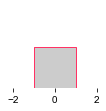

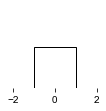

In [30]:
pmaker = plotting.ShapeSpaceMapperPlotMaker(control, "./")
pmaker.set_dataframe(smapper.result)
pmaker.plot_mapping_1d(display_both=False)

In [31]:
for (fig, _), name in zip(pmaker.figs, ["hists", "hists_matched"]):
    fig.savefig(f"{name}.pdf")

### Reconstruct shapes of individual and matched datasets

In [32]:
# These variables should match between control and perturbed dataset
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
outer_alias = control.get_outer_most_alias_to_parameterize()

In [33]:
# path_step = Path(datasets["edges"]["perturbed"]) / "shapemode"
config_pt = general.load_config_file(datasets["pca62"]["perturbed"])
control_pt = controller.Controller(config_pt)
device_pt = io.LocalStagingIO(control_pt)

In [34]:
meshes = {"ct": {}, "pt": {}, "mt": {}}
meshes["ct"]["inner"] = device.read_mean_shape_mesh(inner_alias)
meshes["ct"]["outer"] = device.read_mean_shape_mesh(outer_alias)
meshes["pt"]["inner"] = device_pt.read_mean_shape_mesh(inner_alias)
meshes["pt"]["outer"] = device_pt.read_mean_shape_mesh(outer_alias)
meshes["mt"]["inner"] = device.read_vtk_polydata(f"./avgshape/pca62_{inner_alias}_matched.vtk")
meshes["mt"]["outer"] = device.read_vtk_polydata(f"./avgshape/pca62_{outer_alias}_matched.vtk")

In [35]:
instances = []
for _, mesh in meshes.items():
    domain, _ = cytoparam.voxelize_meshes([mesh["outer"], mesh["inner"]])    
    domain = np.pad(domain, ((5,5),(5,5),(5,5)))
    domain_nuc = (255*(domain>1)).astype(np.uint8)
    domain_mem = (255*(domain>0)).astype(np.uint8)
    instances.append(np.stack([domain_nuc, domain_mem, domain_mem], axis=0))

In [38]:
instances[0].shape <<<<< not working here

(3, 50, 135, 363)

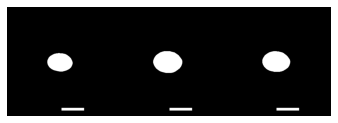

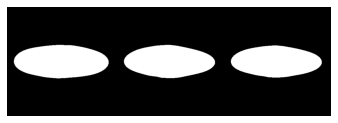

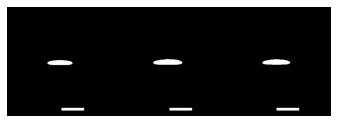

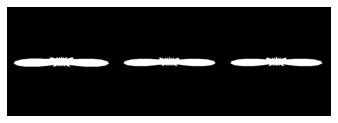

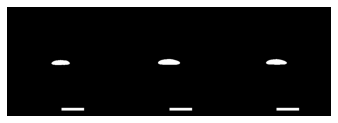

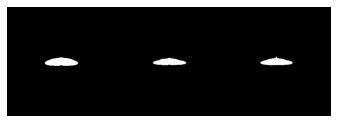

In [41]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
importlib.reload(common)
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.1}, "sharex": True, "sharey": True}
for orient in ["z", "y", "x"]:
    for alias in ["nuc", "mem"]:
        fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=400)
            proj.set_projection_mode(ax=orient, mode=mode)
            proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.18, "length":15})
        plt.savefig(f"Figure1_shapes_{alias}_{orient}.png", dpi=150)
        plt.show()

In [42]:
common.now("complete")

complete 2023-04-26 21:56:43
